### Dependencies
This assumes you have `pandas`, `numpy`, `jupyterlab`, `plotly`, `scikit-optimize`, and `pandas-ta` available in your system or virtual environment. 
You also need `ta-lib`, on macOS you can get it with `brew install ta-lib`

### Configuration
Create a file called `.env` with:
```env
EXCHG_API_KEY=d019f019ca0918c0ac80
EXCHG_SECRET=ba19ca9310de910
```

In [30]:
import sys
# install dependencies
!{sys.executable} -m pip install -q matplotlib ipywidgets plotly pyjuque

ERROR: Could not find a version that satisfies the requirement sciki (from versions: none)
ERROR: No matching distribution found for sciki
You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-s5F4ixgX-py3.9/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/revmischa/pyjuque (to revision patch-1) to /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-ft6fqcpd
  Running command git clone -q https://github.com/revmischa/pyjuque /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-ft6fqcpd
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-s5F4ixgX-py3.9/bin/python -m pip install --upgrade pip' command.


In [34]:
import time
import os
from pprint import pprint
import logging
import cProfile
from typing import Dict
import datetime
import math
from IPython.display import HTML
from copy import deepcopy
from dotenv import load_dotenv
import concurrent.futures as fut
from queue import Queue

import numpy as np
import pandas as pd
import pandas_ta as ta
import skopt.plots as skplots
import sklearn.dummy
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize, BayesSearchCV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import Optimizer, load
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import plotly

from pyjuque.Bot import defineBot
from pyjuque.Plotting import PlotData, GetPlotData
from pyjuque.Exchanges.CcxtExchange import CcxtExchange
from pyjuque.Engine.BacktesterSundayTheQuant import Backtester
from pyjuque.Strategies import StrategyTemplate

%matplotlib inline
#%%capture stored_output

# connect to your exchange
exchange = CcxtExchange("ftx")

In [35]:
timeframe = '15s'  # 1 minute timeframe
starting_balance = 1000. # dollars
symbol = 'ETH-PERP'

# configure your exchange here via .env file
load_dotenv()
api_key = os.environ["EXCHG_API_KEY"]
secret = os.environ["EXCHG_SECRET"]
exchange_config = {
    "exchange": {
        "name": "ftx",
        "params": {
            "api_key": api_key,
            "secret": secret,
        },
    },
}

def gen_config(
    StratClass,
    signal_distance,
    take_profit,
    stop_loss_value,
    params: Dict[str, float],
    test_run=True,
) -> dict:
    if not params:
        params = {}
    return {
        "name": "simulator",
        "test_run": test_run,
        **exchange_config,
        "symbols": [ symbol ],
        "starting_balance": starting_balance,
        "strategy": {"class": StratClass, "params": params},
        "timeframe": timeframe,
        "entry_settings": {
            "initial_entry_allocation": 5,
            "signal_distance": signal_distance,  # pct under buy signal to place order
            "leverage": 1,
        },
        "exit_settings": {
            "take_profit": take_profit,
            "stop_loss_value": stop_loss_value,
            "exit_on_signal": True,
            "sell_on_end": True,
        },
    }


In [36]:
# how many units of timeframe (15s) to test back in time
backtest_times = 4 * 60 * 24 * 60#days
#backtest_times = 4 * 60 * 12#hours

# utilities
symbol_df_cache: Dict[str, pd.DataFrame] = {
    symbol: exchange.getOHLCV(symbol, timeframe, backtest_times)
}


def backtest(bot_config: dict) -> Backtester:
    bt = Backtester(bot_config)
    results = {}
    for symbol in bot_config["symbols"]:
        # fetch historical exchange data (OHLCV) for symbol
        # backtesting will be performed on this dataset
        if not symbol in symbol_df_cache:
            # TODO: fetch several pages
            symbol_df_cache[symbol] = exchange.getOHLCV(symbol, bot_config['timeframe'], backtest_times)
        df = symbol_df_cache[symbol]

        # backtest
        bt.backtest(df)
        results[symbol] = dict(results=bt.return_results(), entries=bt.entries, exits=bt.exits, df=df)
        
    return results

def plot_backtest_results(title, df, entries, exits):
    return PlotData(df, 
        plot_indicators=[
            dict(name = 'slow_ma', title = 'Slow HMA'),
            dict(name = 'fast_ma', title = 'Fast HMA'),
        ],
        signals=[
            dict(name = 'Buy', points = entries), 
            dict(name = 'Sell', points = exits),
        ], 
        add_volume=False,
        plot_title=title,
    )

In [37]:
# strategy to run
class EMACross(StrategyTemplate):
    """Bollinger Bands x RSI"""

    minimum_period: int

    def __init__(self, fast_ma_len=5, slow_ma_len=15):
        self.fast_ma_len = fast_ma_len
        self.slow_ma_len = slow_ma_len
        # the minimum number of candles needed to compute our indicators
        self.minimum_period = max(60, slow_ma_len)

    # the bot will call this function with the latest data from the exchange
    # passed through df; this function computes all the indicators needed
    # for the signal
    def setUp(self, df):
        df["slow_ma"] = ta.ema(df["close"], self.slow_ma_len)
        df["fast_ma"] = ta.ema(df["close"], self.fast_ma_len)
        self.dataframe = df

    # the bot will call this function with the latest data and if this
    # returns true, our bot will place an order
    def checkLongSignal(self, i=None):
        """ """
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            df["low"][i - 1] < df["slow_ma"][i - 1]
            and df["low"][i] > df["slow_ma"][i]
            and df["low"][i] > df["fast_ma"][i]
            and df["fast_ma"][i] > df["slow_ma"][i]
        ):
            return True
        return False

    def checkShortSignal(self, i=None):
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            (
                df["low"][i - 1] > df["slow_ma"][i - 1]
                or df["fast_ma"][i - 1] > df["slow_ma"][i - 1]
            )
            and df["close"][i] < df["slow_ma"][i]
            and df["close"][i] < df["fast_ma"][i]
            and df["fast_ma"][i] < df["slow_ma"][i]
        ):
            return True
        return False

In [147]:
# search space
fast_ma_len = Integer(name='fast_ma_len', low=1.0, high=12.0)
slow_ma_len = Integer(name='slow_ma_len', low=12.0, high=40.0)
# number between 0 and 100 - 1% means that when we get a buy signal, 
# we place buy order 1% below current price. if 0, we place a market 
# order immediately upon receiving signal
signal_distance = Real(name='signal_distance', low=0.0, high=1.5)
# take profit value between 0 and infinity, 3% means we place our sell 
# orders 3% above the prices that our buy orders filled at
take_profit = Real(name='take_profit', low=0.01, high=0.9)
stop_loss_value = Real(name='stop_loss_value', low=0.01, high=4.0)
#dimensions = [fast_ma_len, slow_ma_len, signal_distance, take_profit, stop_loss_value]
dimensions = [take_profit, stop_loss_value]

def calc_strat_loss(backtest_res) -> float:
    """Given backtest results, calculate loss.
    
    Loss is a measure of how badly we're doing.
    """
    score = 0
    
    for symbol, symbol_res in backtest_res.items():
        symbol_bt_res = symbol_res['results']
        profit_realised = symbol_bt_res['profit_realised']
        profit_after_fees = symbol_bt_res['profit_after_fees']
        winrate = symbol_bt_res['winrate']

        if profit_after_fees <= 0:
            # failed to make money.
            # bad.
            return 1

        # how well we're doing (positive)
        score += profit_after_fees * winrate
        
    if score <= 0:
        # not doing so good
        return 1

    # return loss; lower number is better
    return math.pow(0.99, score)

def params_to_bot_config(p):
    params = {**p}
    # strat params
    fast_ma_len = params.pop('fast_ma_len', 7)
    slow_ma_len = params.pop('slow_ma_len', 15)
    if not 'signal_distance' in params:
        params['signal_distance'] = 0
    bot_config = gen_config(
        StratClass=EMACross, 
        params=dict(fast_ma_len=fast_ma_len, slow_ma_len=slow_ma_len),
        **params
    )
    return bot_config

In [148]:
@use_named_args(dimensions=dimensions)
def objective(**params):
    """This is our fitness function.
    
    It takes a set of parameters and returns the "loss" - an objective single scalar to minimize.
    """
    profile = False
    
    if profile:
        pr = cProfile.Profile()
        pr.enable()

    bot_config = params_to_bot_config(params)
    
    try:
        backtest_res = backtest(bot_config)
    except Exception as ex:
        print(ex)
        if 'Not enough data' in str(ex) or 'TA_BAD_PARAM' in str(ex):
            return 1  # bad input
        raise ex
    finally:
        if profile:
            pr.disable()
            pr.dump_stats('objective')

    return calc_strat_loss(backtest_res)

# Optimizer runner

This is a somewhat custom wrapper around the scikit-optimize `Optimizer` interface that is able to save and restore checkpoints. Since running the optimizer can take hours or days, it helps to be able to interrupt it at times and continue where you left off. 

Also it is designed to be as parallel as possible.

In [149]:
# unused - simple and boring way of calling an optimizer
def opt_strat_sk(n_calls) -> Dict[str, float]:
    start_time = time.time()
    opt_res = forest_minimize(func=objective,
                          dimensions=dimensions,
                          n_calls=n_calls, base_estimator="ET",
                          random_state=None)
    elapsed = time.time() - start_time
    print(f"{n_calls} calls, elapsed={elapsed:0.2f}s, rate={n_calls/elapsed:0.1f} calls/s")
    return opt_res

# starting point for optimizer
x0 = None
y0 = None
version = 15
checkpoint_file = f'checkpoint-v{version}.pkl'
checkpoint_saver = CheckpointSaver(checkpoint_file, compress=7) # keyword arguments will be passed to `skopt.dump`

#acq_func = "EI"
#base_estimator = "RF"

def create_optimizer():
    # try to load checkpoint
    global x0
    global y0
    res = None
    try:
        res = load(checkpoint_file)
        if res:
            x0 = res.x_iters
            y0 = list(res.func_vals)
            print(f"Loaded {len(x0)} iterations")
    except FileNotFoundError as fe:
        pass
    
    opt_opts = dict()
    if x0 and len(x0):
        opt_opts['n_initial_points'] = len(x0) 

    optimizer = Optimizer(
        dimensions=dimensions,
        random_state=None,  # random seed
        n_jobs=-1,  # number of cores
        **opt_opts,
        #acq_func=acq_func,
        #base_estimator=base_estimator,
        #base_estimator=sklearn.dummy.DummyRegressor()
    )
    if x0 is not None and y0 is not None and len(y0):
        optimizer.tell(x0, y0)
    return optimizer

optimizer = create_optimizer()

PROFILING = False
ask_timers = []
obj_timers = []
def opt_strat_sk_parallel(n_calls:int):
    start_time = time.time()
    if PROFILING:
        pr = cProfile.Profile()
        pr.enable()

    parallel = 8
    done = False
    start = len(x0) if x0 else 0
    print(f"Start: {start}")
    pq = Queue(100)  # points to check         
    
    # start asking for points to test in a separate thread
    # this is usually the bottleneck so it should be running the whole time
    def get_points():
        while not done:
            ask_start = time.time()
            points = optimizer.ask(n_points=4) # get next points to test - very slow
            elapsed = time.time() - ask_start
            ask_timers.append(elapsed)
            pq.put(points)
                          
    exc = fut.ThreadPoolExecutor(1)
    points_future = exc.submit(get_points)
    
    opt_res = None
    i = start
    while i < n_calls:
        x = pq.get()  # get points to test from queue  
        point_count = len(x)
        if i % 5 == 0 and i != 0 and i != start:
            print(f"{i}...")
            
        # backtest
        obj_start = time.time()
        y = Parallel(n_jobs=point_count)(delayed(objective)(v) for v in x)  # evaluate points in parallel
        
        # record time
        for _ in range(point_count):
            obj_timers.append(time.time() - obj_start)
            
        opt_res = optimizer.tell(x, y)
        
        i += point_count
        
        # checkpoint
        try:
            checkpoint_saver(opt_res)
        except KeyboardInterrupt as ki:
            print("Re-saving...")
            checkpoint_saver(opt_res)
            done = True
        if done:
            break
        
    done = True
    points_future.cancel()
    exc.shutdown(wait=False)

    if PROFILING:
        pr.disable()
        pr.dump_stats('profile')
    elapsed = time.time() - start_time
    print(f"{n_calls} calls, elapsed={elapsed:0.2f}s, rate={(n_calls-start)/elapsed:0.1f} calls/s")

In [150]:
def get_best_result(opt=None):
    min_loss = 1.0
    best_params = None
    if not opt:
        opt = optimizer #create_optimizer()
    for i, x in enumerate(opt.Xi):
        loss = opt.yi[i]
        if loss < min_loss:
            min_loss = loss
            best_params = x
    print("Best:", min_loss)
    best_config = dict(zip([d.name for d in dimensions], best_params))
    print(best_config)
    best_opt_result = opt.get_result() #opt.tell(best_params, min_loss)
    return (best_params, best_config, best_opt_result)

In [151]:
opt_strat_sk_parallel(n_calls=800)

Start: 0
20...
40...
60...
80...
100...
120...
140...
160...
180...
200...
220...
240...
260...
280...
300...
320...
340...
360...
380...
400...
420...
440...
460...
480...
500...
520...
540...
560...
580...
600...
620...
640...
660...
680...
700...
720...
740...
760...
780...
800 calls, elapsed=4302.87s, rate=0.2 calls/s


In [152]:
best_params, best_config, best_opt_result = get_best_result(optimizer)

Best: 0.995568772739961
{'take_profit': 0.4287459925403989, 'stop_loss_value': 0.13221831166947703}


In [153]:
best_config = params_to_bot_config(best_config)
bt_res = backtest(best_config)

In [154]:
alloc = best_config['entry_settings']['initial_entry_allocation']
entry_exit_marker_size = 15
def fix_series_ts(initial_entry_allocation: float, series:list[tuple]):
    ret = []
    for e in series:
        n = [*e]
        n[0] = pd.to_datetime(n[0] * 10e5)
        n[2] = entry_exit_marker_size
        ret.append(n)
    return ret

# formatting and massaging results
symbol_bt_res = bt_res[symbol]
res = symbol_bt_res['results']
pprint(res)
profit = res['profit_after_fees']
initial = res['balance_initial']
bal = res['balance_plus_profits']
print(f"{symbol}: Initial {initial}, profit: {profit:0.3}, return %{(bal/float(initial)*100):.6}")
df = symbol_bt_res['df']

# visualize trades made during backtesting
# date and time columns are broken
df2 = df.drop(columns=['date'])
df2['time'] = pd.to_datetime(df['time'] * 10e5)
# generate plotly figure
fig = plot_backtest_results(
    symbol, 
    df2, 
    fix_series_ts(alloc, symbol_bt_res['entries']), 
    fix_series_ts(alloc, symbol_bt_res['exits'])
)

# will render inline a nice visualization of buy/sell events on a candlestick chart
fig

{'balance_free': 1000.0,
 'balance_initial': 1000.0,
 'balance_locked': 0.0,
 'balance_plus_profits': 1002.0070053217291,
 'n_locked_trades': 0,
 'n_long': 174,
 'n_losing_trades': 85,
 'n_profitable_trades': 24,
 'n_shorts': 0,
 'n_trades': 283,
 'profit': 2.0070053217291495,
 'profit_after_fees': 2.0068860553019925,
 'profit_buy_and_hold': 28.730045579245143,
 'profit_realised': 2.0070053217291495,
 'profit_unrealised': 0.0,
 'winrate': 0.22018348623853212}
ETH-PERP: Initial 1000.0, profit: 2.01, return %100.201


FigureWidget({
    'data': [{'close': array([4629.3, 4630.8, 4631. , ..., 4765.5, 4763. , 4762.3]),
          …

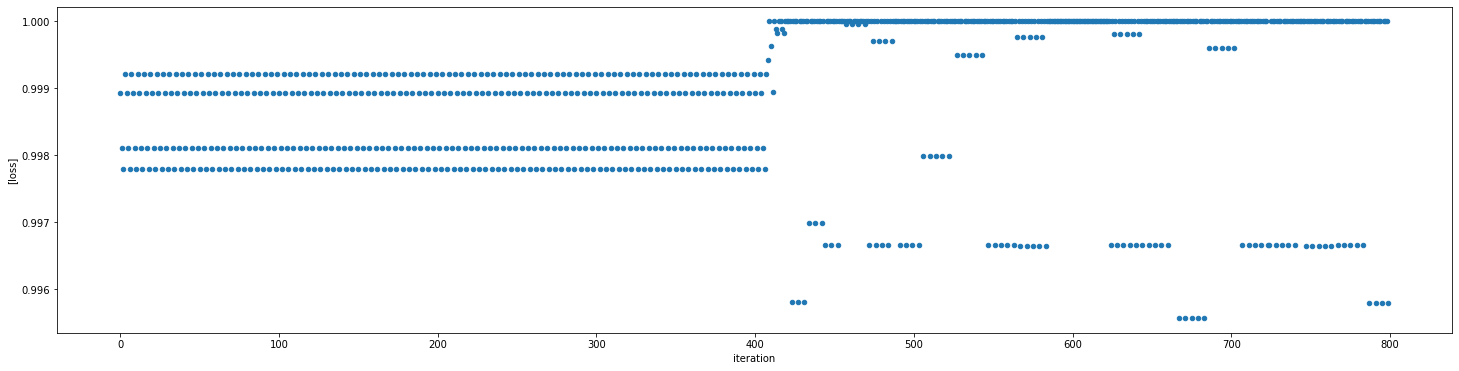

In [155]:
# trials w/ results
btdf = pd.DataFrame({
    'loss': optimizer.yi, 
    'iteration': range(len(optimizer.yi)),
})
btdf['l'] = btdf['loss']
fig = btdf.plot.scatter('iteration', y=['loss'], logy=False, figsize=(25,6))

In [156]:
len(optimizer.yi)

800

In [157]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='signal_distance', dimension_identifier2='take_profit')

TypeError: list indices must be integers or slices, not NoneType

In [161]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='signal_distance', dimension_identifier2='stop_loss_value')

TypeError: list indices must be integers or slices, not NoneType

<AxesSubplot:xlabel='stop_loss_value', ylabel='take_profit'>

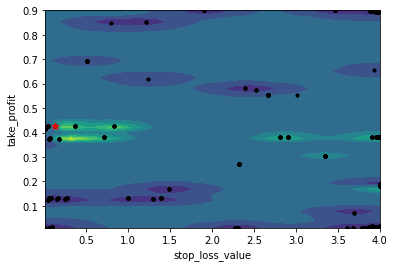

In [162]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='stop_loss_value', dimension_identifier2='take_profit')

In [ ]:
_ = skplots.plot_evaluations(best_opt_result)

In [158]:
obj_timing_df = pd.DataFrame({'objective': obj_timers})
ask_timing_df = pd.DataFrame({'ask': ask_timers})

<AxesSubplot:>

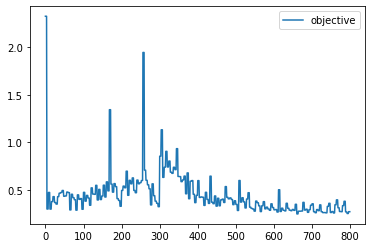

In [159]:
obj_timing_df.plot()

<AxesSubplot:>

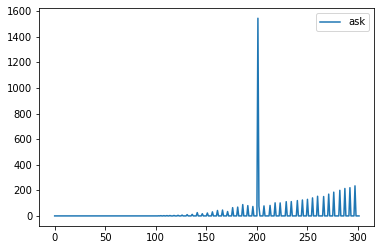

In [160]:
ask_timing_df.plot()

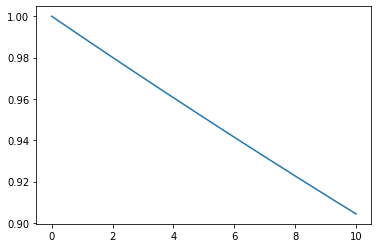

In [146]:
x = np.linspace(0,10,1000)

fig, ax = plt.subplots()
ax.plot(x, np.power(0.99, x))
plt.show()